# Socratic Models for Multimodal Reasoning
## Introduction
In this notebook, we use the Socratic models approach applied to multimodal reasoning tasks, i.e, chain-of-thought (CoT) reasoning & visual question-answering (VQA)

### Imports

In [1]:
# global
import sys
import matplotlib.pyplot as plt
from dotenv import load_dotenv
load_dotenv()
# local 
sys.path.insert(0, '../')
from scripts.mm_reasoning import MmReasoner
# extensions
%load_ext autoreload
%autoreload 2

In [2]:
# Instantiate the multimodal reasoner class.
mm_reasoner = MmReasoner()

Found cached dataset parquet (/Users/ryanamaudruz/.cache/huggingface/datasets/derek-thomas___parquet/derek-thomas--ScienceQA-ca4903a3b5795914/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


load_places starting!
load_places took 0.0s!
load_objects starting!
load_objects took 0.0s!


## Chain-of-thought reasoning

### Data
We use the [ScienceQA](https://scienceqa.github.io/) dataset.

### Zero-shot CoT reasoning
Generate prompts using image info (CLIP) and questions, hints and choices from the dataset, along with a sentence to induce zero-shot CoT reasoning. Generate outputs (solution + rationale) from LM.

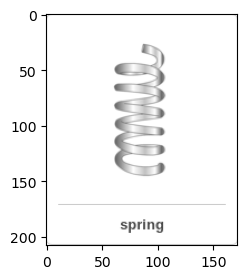

question: Which property matches this object?
choices: ['flexible', 'slippery']
answer: 0
solution: Look at the object.
Think about each property.
A flexible object can be folded or bent without breaking easily. The spring is flexible.
A slippery object is hard to hold onto or stand on. The spring is not slippery.


In [3]:
# select & viz sample
sample_idx = 142
sample = mm_reasoner.sqa_dataset[sample_idx]
plt.figure(figsize=(3, 3))
plt.imshow(sample['image'])
plt.show()
print(f'question: {sample["question"]}\nchoices: {sample["choices"]}\nanswer: {sample["answer"]}\nsolution: {sample["solution"]}')

In [4]:
# compose prompt
prompt = mm_reasoner.create_cot_prompt(sample)
print(f'prompt: {prompt}\n')

prompt: This image was taken in a drugstore. It contains a spring, coil spring, volute spring, spring balance, spring scale, coil, spiral, volute, whorl, helix, sprig, spiral, volute, spritzer, set gun, spring gun, annual, whipping cream, light whipping cream.
Question: Which property matches this object?
Choices: ['flexible', 'slippery']
Hint: Select the better answer.
Answer: Let's think step by step...



In [5]:
# generate output from gpt3
lm_params = {'max_tokens': 100, 'temperature': 1., 'n': 1}
output = mm_reasoner.gpt_manager.get_response_gpt(prompt, **lm_params)
print(f'output: {output}\ngt solution: {sample["solution"]}\ngt answer: {sample["answer"]}')

output: The image contains various objects related to springs and other things like whipping cream and set guns. However, the question is asking which property matches this object. It is not clear which object specifically is being referred to here. Therefore, without more information, it is difficult to provide a definitive answer. Neither "flexible" nor "slippery" seem to be a clear match for any of the objects mentioned, so it is impossible to choose between them as a better answer.
gt solution: Look at the object.
Think about each property.
A flexible object can be folded or bent without breaking easily. The spring is flexible.
A slippery object is hard to hold onto or stand on. The spring is not slippery.
gt answer: 0


### Few-shot CoT reasoning
Generate prompts using image info (CLIP) and questions, hints and choices from the dataset, along with previous prompts & solutions (rational + choice) to induce few-shot CoT reasoning. Generate outputs from LM.

example sample:


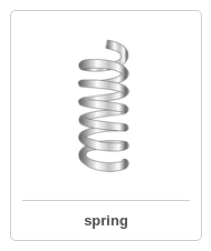

question: Which property matches this object?
choices: ['flexible', 'slippery']
answer: 0
solution: Look at the object.
Think about each property.
A flexible object can be folded or bent without breaking easily. The spring is flexible.
A slippery object is hard to hold onto or stand on. The spring is not slippery.
target sample:


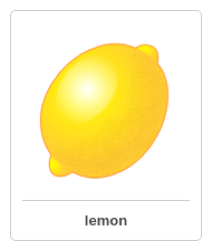

question: Which property matches this object?
choices: ['yellow', 'salty']
answer: 0
solution: Look at the object.
Think about each property.
Potato chips have a salty taste. The lemon is not salty.
Yellow is a color.
This color is yellow. The lemon is yellow.


In [6]:
# select & viz example & target samples
# sample example
eg_sample_idx, target_sample_idx = 142, 523
eg_sample, target_sample = mm_reasoner.sqa_dataset[eg_sample_idx], mm_reasoner.sqa_dataset[target_sample_idx]
# show example sample
print('example sample:')
plt.figure(figsize=(3, 3))
plt.imshow(eg_sample['image'])
plt.axis('off')
plt.show()
print(f'question: {eg_sample["question"]}\nchoices: {eg_sample["choices"]}\nanswer: {eg_sample["answer"]}\nsolution: {eg_sample["solution"]}')

# show target sample
print('target sample:')
plt.figure(figsize=(3, 3))
plt.imshow(target_sample['image'])
plt.axis('off')
plt.show()
print(f'question: {target_sample["question"]}\nchoices: {target_sample["choices"]}\nanswer: {target_sample["answer"]}\nsolution: {target_sample["solution"]}')

In [7]:
# generate prompt
question1 = mm_reasoner.create_cot_prompt(eg_sample)
response1 = f'{eg_sample["solution"]}. So the answer is {eg_sample["choices"][eg_sample["answer"]]}\n'
question2 = mm_reasoner.create_cot_prompt(target_sample)
prompt = question1 + response1 + question2
print(f'prompt: {prompt}\n')

prompt: This image was taken in a drugstore. It contains a spring, coil spring, volute spring, spring balance, spring scale, coil, spiral, volute, whorl, helix, sprig, spiral, volute, spritzer, set gun, spring gun, annual, whipping cream, light whipping cream.
Question: Which property matches this object?
Choices: ['flexible', 'slippery']
Hint: Select the better answer.
Answer: Let's think step by step...Look at the object.
Think about each property.
A flexible object can be folded or bent without breaking easily. The spring is flexible.
A slippery object is hard to hold onto or stand on. The spring is not slippery.. So the answer is flexible
This image was taken in a ball pit. It contains a citron, lemon, lemon, lemon tree, Citrus limon, fruit drink, ade, vitamin C, C, ascorbic acid, citrus, citrus fruit, citrous fruit, vitamin B2, vitamin G, riboflavin, lactoflavin, ovoflavin, hepatoflavin, lime, bergamot, bergamot orange, Citrus bergamia, lemon curd, lemon cheese.
Question: Which pr

In [8]:
# generate outputs from LM
lm_params = {'max_tokens': 100, 'temperature': 1., 'n': 1} 
output = mm_reasoner.gpt_manager.generate_response(prompt, **lm_params)
print(f'output: {output}\ngt solution: {target_sample["solution"]}\ngt answer: {target_sample["answer"]}')

output: Look at the object.
Think about each property.
A yellow object is the color of sunshine or the moon. The ball pit contains mostly yellow balls.
A salty object has a lot of salt in it. The ball pit does not have a lot of salt in it. So the answer is yellow.
gt solution: Look at the object.
Think about each property.
Potato chips have a salty taste. The lemon is not salty.
Yellow is a color.
This color is yellow. The lemon is yellow.
gt answer: 0


## Visual question-answering (VQA)
Visual question-answering using VLM (CLIP) + LM
### Zero-shot VQA

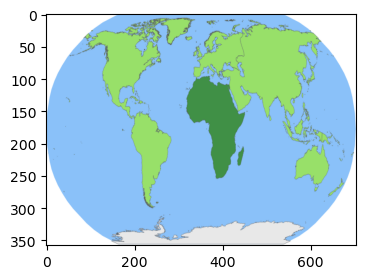

question: Which continent is highlighted?
choices: ['Asia', 'North America', 'Africa', 'South America']
answer: 2
solution: This continent is Africa.


In [9]:
# get sample
sample_idx = 148
sample = mm_reasoner.sqa_dataset[sample_idx]
# show sample
plt.figure(figsize=(4, 3))
plt.imshow(sample['image'], aspect='auto')
plt.show()
print(f'question: {sample["question"]}\nchoices: {sample["choices"]}\nanswer: {sample["answer"]}\nsolution: {sample["solution"]}')

In [10]:
# compose prompt
prompt = mm_reasoner.create_vqa_prompt(sample)
print(f'prompt: {prompt}\n')

prompt: This image was taken in a rainforest. It contains a Black African, region, African, geographical area, geographic area, geographical region, geographic region, region, part, asclepiad, North American, sphere, sphere of influence, map, South African. Using this information, answer the following question: Which continent is highlighted?
Hint: 
Select the index of the correct choice: ['0 Asia', '1 North America', '2 Africa', '3 South America'].Your answer should be a single integer (no text) and you must choose exactly one of the options.
Answer:



In [11]:
# generate outputs from LM
lm_params = {'max_tokens': 20, 'temperature': 1.}
output = mm_reasoner.gpt_manager.get_response_gpt(prompt, **lm_params)
print(f'output: {output}\ngt answer: {sample["answer"] }')

output: 2
gt answer: 2


### Few-shot VQA

example sample:


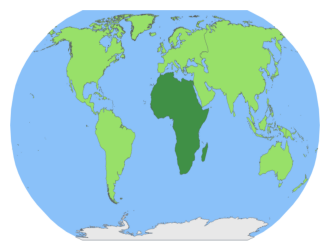

question: Which continent is highlighted?
choices: ['Asia', 'North America', 'Africa', 'South America']
answer: 2
target sample:


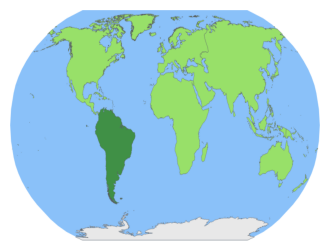

question: Which continent is highlighted?
choices: ['South America', 'Antarctica', 'North America']
answer: 0



In [12]:
# select & viz example & target samples
# sample example
eg_sample_idx, target_sample_idx = 148, 134
eg_sample, target_sample =mm_reasoner.sqa_dataset[eg_sample_idx],mm_reasoner.sqa_dataset[target_sample_idx]
# show example sample
print('example sample:')
plt.figure(figsize=(4, 3))
plt.imshow(eg_sample['image'], aspect='auto')
plt.axis('off')
plt.show()
print(f'question: {eg_sample["question"]}\nchoices: {eg_sample["choices"]}\nanswer: {eg_sample["answer"]}')

# show target sample
print('target sample:')
plt.figure(figsize=(4, 3))
plt.imshow(target_sample['image'], aspect='auto')
plt.axis('off')
plt.show()
print(f'question: {target_sample["question"]}\nchoices: {target_sample["choices"]}\nanswer: {target_sample["answer"]}\n')

In [13]:
# generate prompt
prompt = mm_reasoner.create_vqa_prompt(eg_sample) + f'{eg_sample["answer"]}\n' + mm_reasoner.create_vqa_prompt(target_sample)
print(f'prompt: {prompt}\n')

prompt: This image was taken in a rainforest. It contains a Black African, region, African, geographical area, geographic area, geographical region, geographic region, region, part, asclepiad, North American, sphere, sphere of influence, map, South African. Using this information, answer the following question: Which continent is highlighted?
Hint: 
Select the index of the correct choice: ['0 Asia', '1 North America', '2 Africa', '3 South America'].Your answer should be a single integer (no text) and you must choose exactly one of the options.
Answer:2
This image was taken in a rainforest. It contains a Latin American, Latino, region, region, part, South American, North American, geographical area, geographic area, geographical region, geographic region, representation, earth, ground, district, territory, territorial dominion, dominion, map. Using this information, answer the following question: Which continent is highlighted?
Hint: 
Select the index of the correct choice: ['0 South Am

In [14]:
# generate outputs from LM
lm_params = {'max_tokens': 100, 'temperature': 1.}
output = mm_reasoner.gpt_manager.get_response_gpt(prompt, **lm_params)
print(f'output: {output}\ngt solution: {target_sample["solution"]}\ngt answer: {target_sample["answer"]}')

output: 0
gt solution: This continent is South America.
gt answer: 0
